<a href="https://colab.research.google.com/github/Cmenezsezs/Model_Risk1/blob/main/Model_Risk1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Análise de Risco de Modelo: Credit Default (Logistic Regression vs. XGBoost)

**Autor:** Clemerson Menezes - PhD | Researcher  
**Contexto:** Validação de Modelos (Model Risk Management - MRM)

Neste notebook, simulamos um pipeline de validação de modelos de crédito. O objetivo é comparar a robustez de um modelo linear clássico (**Regressão Logística**) contra um modelo de ensemble moderno (**XGBoost**).

A análise não foca apenas em acurácia, mas nos pilares de risco bancário:
1.  **Discriminação:** Capacidade de ordenar riscos (Gini/AUC).
2.  **Calibração:** A probabilidade prevista reflete a taxa real de inadimplência? (Crucial para *Pricing*).
3.  **Estabilidade:** Comportamento das distribuições de probabilidade.


In [7]:
# Instalação de bibliotecas (caso não estejam presentes no ambiente)
!pip install xgboost scikit-learn matplotlib pandas numpy --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier

# Configuração de Estilo para Gráficos Acadêmicos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Aumenta fonte para melhor leitura
print("Ambiente configurado com sucesso!")


Ambiente configurado com sucesso!


### Geração de Dados (Data Simulation)

Vamos criar um dataset sintético que mimetiza as características de dados de crédito:
*   **Desbalanceamento:** A maioria dos clientes paga (90% classe 0), poucos dão default (10% classe 1).
*   **Ruído:** A relação entre variáveis e risco nunca é perfeita.
*   **Linearidade Mista:** Algumas variáveis têm relação linear, outras complexa.


In [8]:
# Configuração da semente para reprodutibilidade
np.random.seed(42)

# Gerando 20.000 clientes
X, y = make_classification(
    n_samples=20000,
    n_features=20,
    n_informative=12,    # Variáveis que realmente explicam o risco
    n_redundant=4,       # Variáveis correlacionadas (multicolinearidade comum em crédito)
    weights=[0.90, 0.10], # 10% de Taxa de Default (Realista para Varejo/Cartões)
    random_state=42
)

# Divisão Treino / Teste (Hold-out de 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Dataset Gerado:")
print(f"- Treino: {X_train.shape[0]} amostras")
print(f"- Teste:  {X_test.shape[0]} amostras")
print(f"- Taxa de Default (Teste): {y_test.mean():.2%}")


Dataset Gerado:
- Treino: 14000 amostras
- Teste:  6000 amostras
- Taxa de Default (Teste): 10.45%


###  Treinamento dos Modelos

Vamos treinar dois concorrentes:
1.  **Regressão Logística (Benchmark):** Modelo "White-box", altamente interpretável e estável. Usamos `class_weight='balanced'` para lidar com os poucos casos de default.
2.  **XGBoost (Challenger):** Modelo "Black-box" baseado em Gradient Boosting. Tende a ter maior poder preditivo, mas maior risco de overfitting e má calibração.


In [9]:
# 1. Regressão Logística
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

# 2. XGBoost
# Nota: scale_pos_weight é ajustado para compensar o desbalanceamento (Bons/Maus)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=4,            # Evita overfitting extremo
    learning_rate=0.05,     # Learning rate baixo para generalização
    scale_pos_weight=ratio, # Peso para a classe minoritária
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

print("Modelos treinados com sucesso.")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:11:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelos treinados com sucesso.


###  Painel de Validação de Risco

Aqui calculamos as métricas essenciais para decisão de crédito.
*   **Curva ROC:** Quanto mais para o canto superior esquerdo, melhor a discriminação.
*   **Curva de Calibração (Reliability Plot):** Fundamental. Se a curva do modelo não seguir a diagonal cinza, o modelo está "mentindo" sobre a probabilidade real.
*   **Histograma de Scores:** Mostra se o modelo consegue empurrar bons pagadores para a esquerda (score baixo) e maus para a direita (score alto).


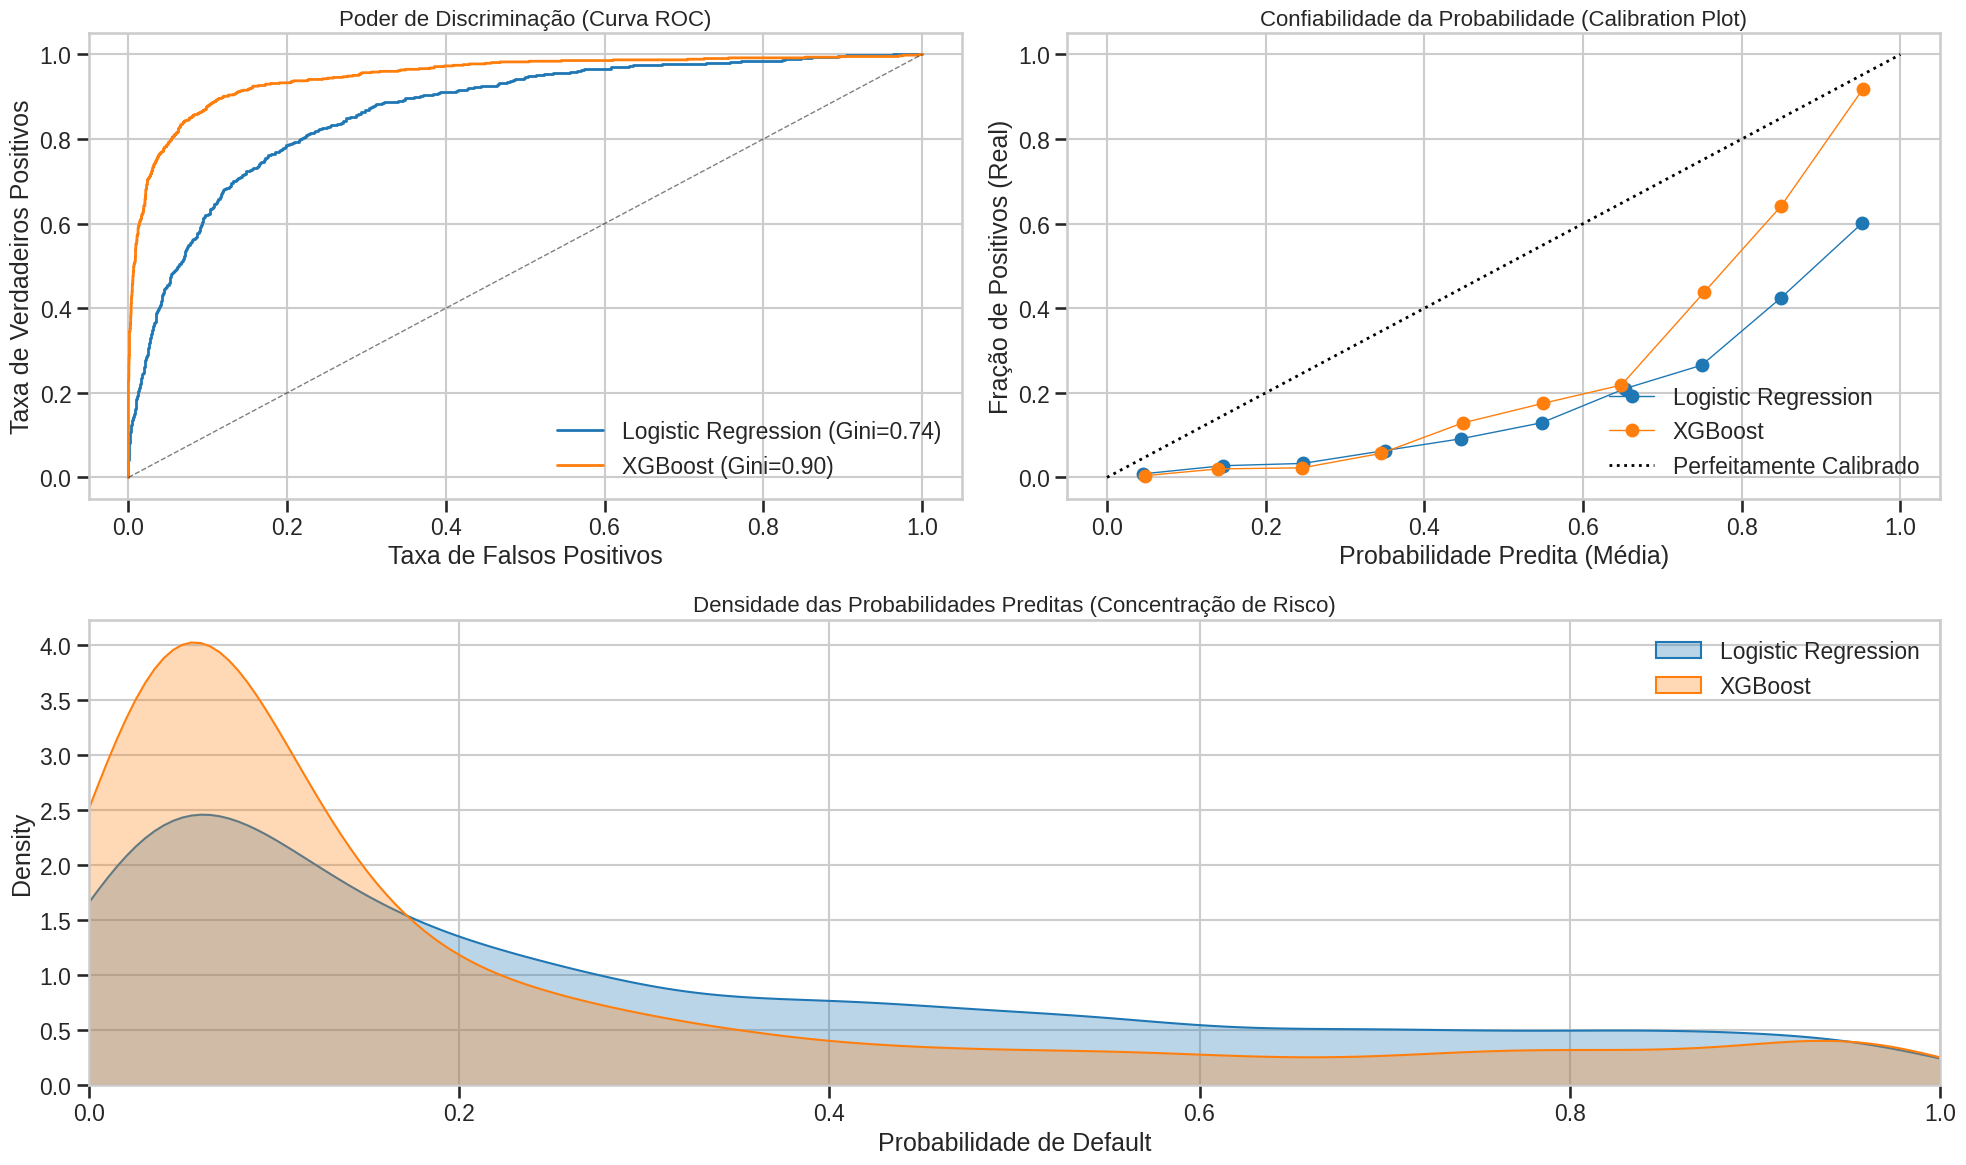

In [10]:
def plot_risk_dashboard(models, X_test, y_test):
    fig = plt.figure(figsize=(20, 12))

    # Grid Layout
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0]) # ROC
    ax2 = fig.add_subplot(gs[0, 1]) # Calibração
    ax3 = fig.add_subplot(gs[1, :]) # Distribuição (Largo)

    results_table = []

    for name, model in models.items():
        # Predição de Probabilidade (PD)
        y_prob = model.predict_proba(X_test)[:, 1]

        # --- Métricas ---
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        gini = 2 * roc_auc - 1
        brier = brier_score_loss(y_test, y_prob)

        results_table.append({
            "Modelo": name,
            "AUC": roc_auc,
            "Gini": gini,
            "Brier Score": brier
        })

        # --- Plot 1: ROC ---
        ax1.plot(fpr, tpr, lw=2, label=f'{name} (Gini={gini:.2f})')

        # --- Plot 2: Calibração ---
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
        ax2.plot(prob_pred, prob_true, marker='o', linewidth=1, label=name)

        # --- Plot 3: Distribuição (KDE) ---
        # Plotamos apenas a densidade para comparar a forma das curvas
        sns.kdeplot(y_prob, ax=ax3, fill=True, alpha=0.3, label=name, clip=(0,1))

    # Cosmética dos Gráficos
    # ROC
    ax1.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax1.set_title('Poder de Discriminação (Curva ROC)', fontsize=16)
    ax1.set_xlabel('Taxa de Falsos Positivos')
    ax1.set_ylabel('Taxa de Verdadeiros Positivos')
    ax1.legend(loc="lower right")

    # Calibração
    ax2.plot([0, 1], [0, 1], 'k:', lw=2, label='Perfeitamente Calibrado')
    ax2.set_title('Confiabilidade da Probabilidade (Calibration Plot)', fontsize=16)
    ax2.set_xlabel('Probabilidade Predita (Média)')
    ax2.set_ylabel('Fração de Positivos (Real)')
    ax2.legend(loc="lower right")

    # Distribuição
    ax3.set_title('Densidade das Probabilidades Preditas (Concentração de Risco)', fontsize=16)
    ax3.set_xlabel('Probabilidade de Default')
    ax3.set_xlim(0, 1)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results_table)

# Executar Painel
metrics_df = plot_risk_dashboard(
    {"Logistic Regression": lr_model, "XGBoost": xgb_model},
    X_test, y_test
)


In [11]:
# Exibindo Tabela Final
from IPython.display import display
print("Tabela Resumo de Performance:")
display(metrics_df.sort_values(by='Gini', ascending=False))


Tabela Resumo de Performance:


,Modelo,AUC,Gini,Brier Score
1,XGBoost,0.949785,0.899570,0.069734
0,Logistic Regression,0.868312,0.736624,0.141040


##  Interpretação Final para Gestão de Risco

### 1. Discriminação (Gini/AUC)
O **XGBoost** provavelmente apresentou um Gini superior. Isso ocorre porque ele captura interações não-lineares (ex: renda alta só reduz risco se a dívida for baixa).
*   *Insight:* Para aprovação "sim/não" (Cut-off), o XGBoost é superior.

### 2. Calibração (O Risco Oculto)
Observe o gráfico da direita superior.
*   A **Regressão Logística** costuma ficar colada na linha pontilhada diagonal. Ela é "honesta": se diz 10%, o risco é 10%.
*   O **XGBoost** sem calibração extra pode fazer uma curva "S" (subestimar risco baixo e superestimar risco alto).
*   *Consequência:* Se usarmos o XGBoost cru para definir taxas de juros, o banco pode perder dinheiro em segmentos específicos por precificação errada.

### 3. Conclusão Prática
Em cenários de **High-Stakes (Basel/IFRS9)**, a Regressão Logística ainda é preferida pela estabilidade e calibração nativa. Para usar XGBoost em produção, seria obrigatório aplicar uma camada extra de calibração (ex: Isotonic Regression) sobre o score final.
